# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, date

# Load Data
* Handle missing values, duplicated values, outlier

In [2]:
# Import the dataset
total = pd.read_csv("https://raw.githubusercontent.com/lavibula/ML20222.PredictionBitcoin/main/working/Data_working.csv")
#cac gia tri row > 4658 duoc xoa -> NULL
total = total.loc[:4658,:] 

# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill "NaN"s with zeroes for relevant fields...
total = total.fillna(method='ffill')

#encode the date
for index in total.index:
  total.loc[index, "Date"] = datetime.strptime(str(total.loc[index, "Date"])[:10], '%d/%m/%Y').date()
print("Is There any 'NaN' value: ", total.isnull().values.any())
print("Is there any duplicate value: ", total.index.duplicated().any())


Is There any 'NaN' value:  True
Is there any duplicate value:  False


# Slpit Data (Testing, Training Data Sets)

In [3]:
"""# split data
prediction_days = 140
df_train = historical_df[:len(historical_df) - prediction_days ]
df_test  = historical_df[ len(historical_df) - prediction_days:]

print("PERCENT test/total data = %", (prediction_days/len(historical_df)) * 100)
print("train data shape:", df_train.shape)
print("test data shape:", df_test.shape)
df_train.head(3)"""

# Indicate the 'start' and 'end' time. 
Start_day = date(2014, 9, 1)
Test_day = date(2018,4,1)
End_day = date(2018,12,31)
# train, test
# find rows between start and end time 
total = total[(total["Date"] >= Start_day) & (total["Date"] <= End_day)].reset_index(drop = True)
train_dataset = total[total["Date"] < Test_day].reset_index(drop = True)
test_dataset = total[total["Date"] >= Test_day].reset_index(drop = True)
print("PERCENT test/total data = %", (len(test_dataset)/len(total)) * 100)

PERCENT test/total data = % 17.37207833228048


In [4]:
X_train = train_dataset.drop(["Date"], axis=1)[:-1]
Y_train = train_dataset["BTC_close"][:-1]
print(X_train.tail())
X_test = test_dataset.drop(["Date"], axis=1)[:-1]
Y_test = test_dataset["BTC_close"][:-1]
print(X_test.tail())

      BTC_close  BTC_open  BTC_high  BTC_low  BTC_volume  Active_Addr_Cnt   
1302      484.5     483.6     491.4    480.8        3.79         152934.0  \
1303      483.6     491.0     495.0    483.1        6.04         188565.0   
1304      491.0     480.0     498.5    476.3        8.81         180670.0   
1305      480.0     478.9     487.3    476.8        6.14         169050.0   
1306      478.9     477.2     487.0    470.5        6.75         191326.0   

        Difficulty  Mean_Block_Size(in_bytes)  Sum_Block_Weight   
1302  2.742863e+10                188863.8715       135226532.0  \
1303  2.742863e+10                282066.6414       163598652.0   
1304  2.742863e+10                251939.6203       159225840.0   
1305  2.742863e+10                232597.5562       157235948.0   
1306  2.742863e+10                286579.8435       168508948.0   

      Total_Fees(USD)  ...    ETH   LTC      DOGE      XRP    GOLD  SILVER   
1302      9059.175419  ...  11.75  3.84  0.003213  0.016

In [5]:
# Again fill NaN
import numpy as np
from sklearn.impute import KNNImputer
imputer_train = KNNImputer(n_neighbors=2, weights="uniform")
imputer_train.fit_transform(X_train)

print("Is There any 'NaN' value: ", X_train.isnull().values.any())
print("Is there any duplicate value: ", X_train.index.duplicated().any())

Is There any 'NaN' value:  False
Is there any duplicate value:  False


# Load Model

In [6]:
#import sklearn modules
from sklearn import tree
from time import *
from sklearn.ensemble import RandomForestRegressor

In [7]:
start_time = time()
simpleTree = RandomForestRegressor(max_depth=10, n_estimators=500)
#Xây dựng cây hồi quy với độ sâu cây là 10 (Random forest), 500 cây
simpleTree.fit(X_train, Y_train)
end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

Time to train model: 5.748 seconds


# Graph Predicted Values with Training Set

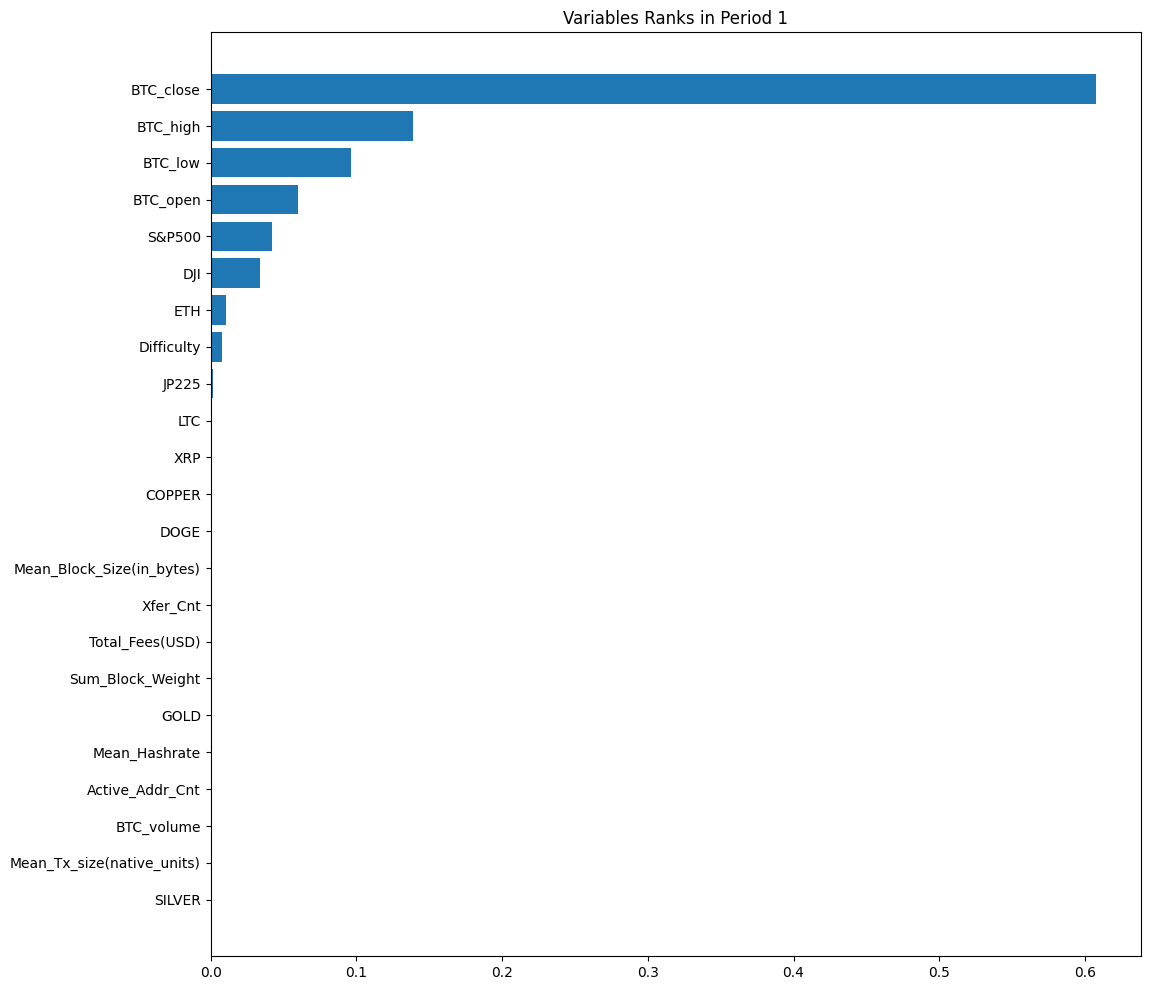

In [8]:
# Importance of variables
features = X_train.columns
importances = simpleTree.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.title("Variables Ranks in Period 1")
plt.show()

In [13]:
explainer = shape.TreeExplainer(simpleTree)
shape_values = explainer.shape_values(X_test)

NameError: name 'shape' is not defined

In [10]:
total_without_date = total.drop('Date', axis=1)
#total_without_date = total_without_date.drop('NEXT_CLOSE', axis=1)

#total_without_date 

In [11]:
#total_without_date.corr()

<Axes: >

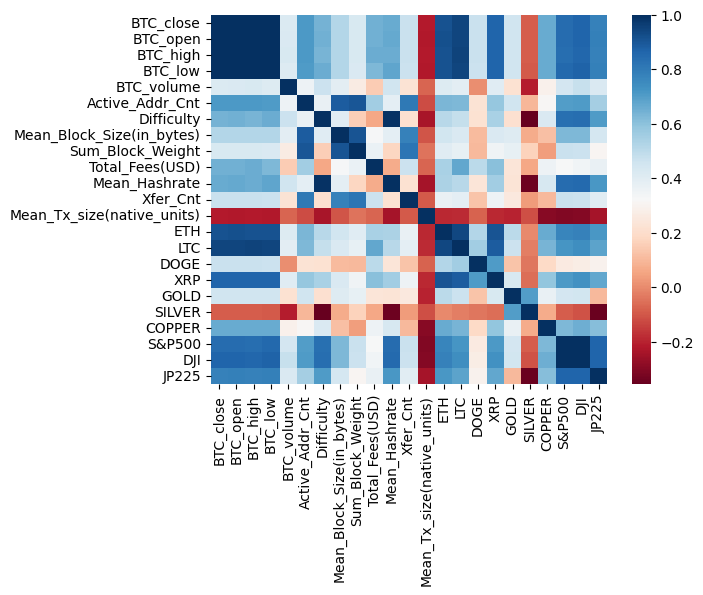

In [12]:
import seaborn as sns
#sns.heatmap(total_without_date.corr(), cmap="viridis")
#sns.heatmap(total_without_date.corr(), cmap="plasma")
#sns.heatmap(total_without_date.corr(), cmap="inferno")
#sns.heatmap(total_without_date.corr(), cmap="magma")
#sns.heatmap(total_without_date.corr(), cmap="cividis")
sns.heatmap(total_without_date.corr(), cmap="RdBu")
#sns.heatmap(total_without_date.corr(), cmap="YlGnBu")
#sns.heatmap(total_without_date.corr(), cmap="YlOrBr")



# Graph Predicted Values with Test Set

In [ ]:
#so sanh cac gia tri du doan va quan sat
Y_pred = simpleTree.predict(X_test)
#hien thi ket qua du doan
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(Y_test, color = 'red', label="Bitcoin Price")
ax.plot(Y_pred, color = 'green', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
plt.title("Random Forest Regression for Period 1")
plt.legend()
plt.show()

# Visualising the results

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.plot(total['Date'], total['BTC_close'], color='red', label="Bitcoin Price")
ax.plot(total['Date'][:len(Y_pred)], Y_pred, color='green', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
plt.title("Random Forest Regression for Period 1")
plt.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(total['Date'], total['BTC_close'], color='blue', label="Bitcoin Price")
ax.plot(total['Date'][-len(Y_train):], Y_train, color='pink', label="Training Data")
ax.plot(total['Date'][:len(Y_test)], Y_test, color='orange', label="Test Data")
ax.plot(total['Date'][:len(Y_pred)], Y_pred, color='purple', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))) # Định dạng đường trục y
plt.legend()
plt.show()


# Evaluation metrics RMSE, MAPE, DA

In [ ]:
#tinh toan loi du doan
#RMSE
from time import *
from sklearn.metrics import mean_squared_error

start_time = time()

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print()

#MAPE
MAPE = np.average(np.abs((Y_test.values - Y_pred) / Y_test.values))
print("MAPE:", MAPE)
print()

#DA
Y_test_DA = np.array(Y_test)
Y_pred_0 = Y_pred[1:] - Y_test_DA[:-1]
Y_test_0 = Y_test[1:] - Y_test_DA[:-1]
DA = (Y_pred_0<0) == (Y_test_0<0)
print("DA accuracy:", f"{round(np.mean(DA)*100, 2)}%")

end_time = time()
elapsed_time = end_time - start_time
print("Time to evaluate model: %.3f seconds" % elapsed_time)

# Some Importance Features 


In [ ]:
X1 = train_dataset.loc[:, 'BTC_close':'BTC_low']
X2 = train_dataset.loc[:, 'ETH':'XRP']
X3 = train_dataset.loc[:, 'COPPER':'JP225']

Xtrain = pd.concat([X1, X2, X3], axis=1)
Xtrain.tail()


# Visualising the Results when Removing some Importance Features

In [ ]:
RMSE_list = []

start_time = time()

for columnName in Xtrain:
    X_train_re = X_train.drop([columnName],axis=1)[1:]
    Y_train_re = X_train['BTC_close'][:-1]

    
    X_test_re = X_test.drop([columnName],axis=1)[1:]
    Y_test_re = X_test['BTC_close'][:-1]

    
    simpleTree = RandomForestRegressor(max_depth=10, n_estimators=500)
    simpleTree.fit(X_train_re, Y_train_re)
    Y_pred_re = simpleTree.predict(X_test_re)
    
    #tinh toan loi du doan
    #RMSE
    from sklearn.metrics import mean_squared_error
    RMSE = np.sqrt(mean_squared_error(Y_test_re, Y_pred_re))
    RMSE_list.append(RMSE)

labels = Xtrain.columns.tolist()
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(14,5))
rects2 = ax.bar(x, RMSE_list, width, label='RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Comparison of RMSE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

end_time = time()
elapsed_time = end_time - start_time
print("Time to evaluate model: %.3f seconds" % elapsed_time)